In [1]:
import pandas as pd
import numpy as np
from pydataset import data
import os
import env
import acquire as a
import prepare as p
import wrangle as w
from sklearn.model_selection import train_test_split

#Stats imports & evaluations
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind, chi2_contingency
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

#visual imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scalers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# modeling method
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
# Intakes csv
intake_df = pd.read_csv('aac_intakes.csv')
intake_df.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A665644,NaN,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
1,A665739,*Alana,10/22/2013 11:11:00 AM,October 2013,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black
2,A665763,NaN,10/22/2013 03:10:00 PM,October 2013,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White
3,A379998,Disciple,10/23/2013 11:42:00 AM,October 2013,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black
4,A634503,Otter,10/01/2013 02:49:00 PM,October 2013,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan


In [3]:
# Outcomes csv
outcome_df = pd.read_csv('aac_outcomes.csv')
outcome_df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


In [4]:
# Intake/Outcome shape
intake_df.shape, outcome_df.shape

((148133, 12), (148339, 12))

In [5]:
intake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148133 entries, 0 to 148132
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         148133 non-null  object
 1   Name              105132 non-null  object
 2   DateTime          148133 non-null  object
 3   MonthYear         148133 non-null  object
 4   Found Location    148133 non-null  object
 5   Intake Type       148133 non-null  object
 6   Intake Condition  148133 non-null  object
 7   Animal Type       148133 non-null  object
 8   Sex upon Intake   148131 non-null  object
 9   Age upon Intake   148132 non-null  object
 10  Breed             148133 non-null  object
 11  Color             148133 non-null  object
dtypes: object(12)
memory usage: 13.6+ MB


In [6]:
outcome_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148339 entries, 0 to 148338
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         148339 non-null  object
 1   Name              105360 non-null  object
 2   DateTime          148339 non-null  object
 3   MonthYear         148339 non-null  object
 4   Date of Birth     148339 non-null  object
 5   Outcome Type      148315 non-null  object
 6   Outcome Subtype   67903 non-null   object
 7   Animal Type       148339 non-null  object
 8   Sex upon Outcome  148336 non-null  object
 9   Age upon Outcome  148279 non-null  object
 10  Breed             148339 non-null  object
 11  Color             148339 non-null  object
dtypes: object(12)
memory usage: 13.6+ MB


In [7]:
# Normalize columns
outcome_df.columns = outcome_df.columns.str.replace(' ','_')
intake_df.columns = intake_df.columns.str.replace(' ','_')

# Lower-case columns
outcome_df.columns = outcome_df.columns.str.lower()
intake_df.columns = intake_df.columns.str.lower()

**Outcome Type is the TARGET**

In [8]:
# Outcome Type Value Counts
outcome_df.outcome_type.value_counts()

Adoption           69093
Transfer           42695
Return to Owner    23808
Euthanasia          9572
Died                1384
Rto-Adopt            993
Disposal             667
Missing               75
Relocate              26
Stolen                 2
Name: outcome_type, dtype: int64

In [9]:
# Intake nulls
intake_df.isna().sum()

animal_id               0
name                43001
datetime                0
monthyear               0
found_location          0
intake_type             0
intake_condition        0
animal_type             0
sex_upon_intake         2
age_upon_intake         1
breed                   0
color                   0
dtype: int64

In [10]:
# Outcome nulls
outcome_df.isna().sum()

animal_id               0
name                42979
datetime                0
monthyear               0
date_of_birth           0
outcome_type           24
outcome_subtype     80436
animal_type             0
sex_upon_outcome        3
age_upon_outcome       60
breed                   0
color                   0
dtype: int64

In [11]:
outcome_df.outcome_subtype.value_counts()

Partner                35333
Foster                 13888
Rabies Risk             4249
Suffering               3682
SCRP                    3211
Snr                     3194
Out State                931
In Kennel                723
Aggressive               584
Offsite                  493
In Foster                349
Medical                  339
At Vet                   311
Behavior                 161
Field                    153
Enroute                   94
Court/Investigation       52
Underage                  37
In Surgery                30
Customer S                18
Possible Theft            16
Prc                       13
Emergency                 12
Barn                      12
In State                  12
Emer                       6
Name: outcome_subtype, dtype: int64

**Drop Outcome Subtype. Only interested in actual outcomes and more than half of data is nulls**

In [12]:
# dropping subtype
outcome_df = outcome_df.drop(['outcome_subtype'],axis=1)
outcome_df.head(3)

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,Other,Unknown,1 year,Raccoon,Gray


In [13]:
# Drop name columns
intake_df = intake_df.drop('name',axis=1)
outcome_df = outcome_df.drop('name',axis=1)

In [14]:
# Merged Data frames
combined = intake_df.merge(outcome_df, on='animal_id')
combined.head(3)

,animal_id,datetime_x,monthyear_x,found_location,intake_type,intake_condition,animal_type_x,sex_upon_intake,age_upon_intake,breed_x,color_x,datetime_y,monthyear_y,date_of_birth,outcome_type,animal_type_y,sex_upon_outcome,age_upon_outcome,breed_y,color_y
0,A665644,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,10/21/2013 11:39:00 AM,Oct 2013,09/21/2013,Transfer,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
1,A665739,10/22/2013 11:11:00 AM,October 2013,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,12/20/2013 05:36:00 PM,Dec 2013,09/16/2013,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Black
2,A665763,10/22/2013 03:10:00 PM,October 2013,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,10/26/2013 06:32:00 PM,Oct 2013,06/22/2013,Adoption,Dog,Neutered Male,4 months,Cairn Terrier Mix,Tan/White


In [15]:
combined.shape

(190609, 20)

In [16]:
# Check if ids match
intake_df[intake_df['animal_id'] == 'A665644']

,animal_id,datetime,monthyear,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color
0,A665644,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico


In [17]:
# Check if ids match
outcome_df[outcome_df['animal_id'] == 'A665644']

,animal_id,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
58227,A665644,10/21/2013 11:39:00 AM,Oct 2013,09/21/2013,Transfer,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico


## Merge intake and outcome Dataframes

In [18]:
# Rename columns
combined = combined.rename(columns={'datetime_x': 'date_intake', 'breed_y':'breed',
                        'datetime_y':'date_outcome','animal_type_x':'animal_type','color_y':'color'})
combined.head(3)

,animal_id,date_intake,monthyear_x,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed_x,color_x,date_outcome,monthyear_y,date_of_birth,outcome_type,animal_type_y,sex_upon_outcome,age_upon_outcome,breed,color
0,A665644,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,10/21/2013 11:39:00 AM,Oct 2013,09/21/2013,Transfer,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
1,A665739,10/22/2013 11:11:00 AM,October 2013,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,12/20/2013 05:36:00 PM,Dec 2013,09/16/2013,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Black
2,A665763,10/22/2013 03:10:00 PM,October 2013,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,10/26/2013 06:32:00 PM,Oct 2013,06/22/2013,Adoption,Dog,Neutered Male,4 months,Cairn Terrier Mix,Tan/White


In [19]:
# Drop columns: breed_x, animal_type_y, monthyear columns, found_location
combined = combined.drop(['breed_x','animal_type_y','color_x', 'monthyear_x','monthyear_y',
                          'found_location','sex_upon_intake'], axis=1)
combined.head(3)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A665644,10/21/2013 07:59:00 AM,Stray,Sick,Cat,4 weeks,10/21/2013 11:39:00 AM,09/21/2013,Transfer,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
1,A665739,10/22/2013 11:11:00 AM,Stray,Normal,Cat,1 month,12/20/2013 05:36:00 PM,09/16/2013,Adoption,Spayed Female,3 months,Domestic Medium Hair Mix,Black
2,A665763,10/22/2013 03:10:00 PM,Stray,Normal,Dog,4 months,10/26/2013 06:32:00 PM,06/22/2013,Adoption,Neutered Male,4 months,Cairn Terrier Mix,Tan/White


In [20]:
combined.isna().sum()

animal_id            0
date_intake          0
intake_type          0
intake_condition     0
animal_type          0
age_upon_intake      1
date_outcome         0
date_of_birth        0
outcome_type        35
sex_upon_outcome     6
age_upon_outcome    63
breed                0
color                0
dtype: int64

In [21]:
# drop nulls, only 107 out of 190k
combined = combined.dropna()
combined.shape

(190511, 13)

In [22]:
combined.animal_type.unique()

array(['Cat', 'Dog', 'Other', 'Bird', 'Livestock'], dtype=object)

In [23]:
# covert date into datetime dtype
combined['date_intake'] = pd.to_datetime(combined.date_intake, infer_datetime_format=True)
combined['date_outcome'] = pd.to_datetime(combined.date_outcome, infer_datetime_format=True)

In [24]:
# Time in shelter
combined['time_in_shelter'] = combined.date_outcome - combined.date_intake

# Just want number of days for time in shelter
combined['time_in_shelter'] = combined.time_in_shelter.dt.days

combined.head(3)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter
0,A665644,2013-10-21 07:59:00,Stray,Sick,Cat,4 weeks,2013-10-21 11:39:00,09/21/2013,Transfer,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,0
1,A665739,2013-10-22 11:11:00,Stray,Normal,Cat,1 month,2013-12-20 05:36:00,09/16/2013,Adoption,Spayed Female,3 months,Domestic Medium Hair Mix,Black,58
2,A665763,2013-10-22 03:10:00,Stray,Normal,Dog,4 months,2013-10-26 06:32:00,06/22/2013,Adoption,Neutered Male,4 months,Cairn Terrier Mix,Tan/White,4


In [25]:
combined.shape

(190511, 14)

In [26]:
# Dropping anything that has negative days. There are values that have over 1000 negative days. 
combined[combined['time_in_shelter'] < 0]

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter
16,A645345,2018-05-12 02:07:00,Owner Surrender,Normal,Dog,6 years,2013-10-20 04:29:00,01/06/2012,Transfer,Spayed Female,1 year,Pit Bull Mix,Brown/White,-1665
20,A665615,2013-10-20 12:01:00,Stray,Normal,Dog,8 years,2013-10-20 03:10:00,05/20/2005,Return to Owner,Spayed Female,8 years,Border Collie/Labrador Retriever,Chocolate/White,-1
26,A665923,2016-07-16 06:07:00,Public Assist,Normal,Dog,4 years,2013-11-04 03:00:00,04/24/2012,Return to Owner,Spayed Female,1 year,German Shepherd/Labrador Retriever,Red,-986
40,A665150,2013-10-14 12:40:00,Stray,Normal,Dog,4 weeks,2013-10-14 03:04:00,09/14/2013,Transfer,Intact Male,4 weeks,Chihuahua Shorthair Mix,Sable,-1
44,A664439,2013-12-16 02:07:00,Stray,Normal,Dog,6 months,2013-10-10 04:39:00,06/03/2013,Adoption,Neutered Male,4 months,Dachshund/Rat Terrier,White/Black,-67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190584,A789210,2023-02-11 12:49:00,Stray,Sick,Cat,12 years,2019-03-26 07:04:00,03/08/2010,Adoption,Spayed Female,9 years,Domestic Shorthair Mix,Calico,-1419
190590,A857409,2022-08-10 01:55:00,Owner Surrender,Normal,Dog,2 years,2022-08-09 07:39:00,05/16/2020,Adoption,Neutered Male,2 years,Pit Bull,Tan/White,-1
190595,A850777,2023-01-27 05:53:00,Stray,Normal,Dog,1 year,2022-02-08 04:43:00,11/22/2021,Adoption,Spayed Female,2 months,German Shepherd Mix,Black/Brown,-354
190603,A865121,2022-10-15 06:20:00,Stray,Normal,Dog,6 months,2022-09-12 05:17:00,04/06/2022,Adoption,Spayed Female,5 months,Siberian Husky,White/Black,-34


In [27]:
# Drop any negative time in shelter values. 48873 values dropped
combined = combined[combined['time_in_shelter'] > 0]

In [28]:
combined.shape

(141638, 14)

## Split into cat and dog dataframes

In [29]:
# Split combined to only be for cats and dogs.
combined_cat = combined[combined['animal_type'] == 'Cat' ]
combined_dog = combined[combined['animal_type'] == 'Dog' ]
combined_cat.shape, combined_dog.shape

((48548, 14), (88873, 14))

In [30]:
combined.outcome_type.unique()

array(['Adoption', 'Return to Owner', 'Transfer', 'Euthanasia', 'Died',
       'Disposal', 'Missing', 'Rto-Adopt', 'Relocate', 'Stolen'],
      dtype=object)

In [31]:
# Value counts Cat
combined_cat.outcome_type.value_counts()

Adoption           29066
Transfer           15261
Return to Owner     2102
Euthanasia          1093
Died                 687
Rto-Adopt            232
Disposal              64
Missing               39
Relocate               4
Name: outcome_type, dtype: int64

In [32]:
# Value counts Dog
combined_dog.outcome_type.value_counts()

Adoption           47124
Return to Owner    20158
Transfer           18369
Euthanasia          1653
Rto-Adopt           1200
Died                 272
Disposal              54
Missing               36
Stolen                 7
Name: outcome_type, dtype: int64

In [33]:
# Drop values that are Rto-Adopt, Died, Disposal, Missing, Stolen, Transfer
combined_dog = combined_dog[combined_dog['outcome_type'] != 'Transfer']
combined_dog = combined_dog[combined_dog['outcome_type'] != 'Rto-Adopt']
combined_dog = combined_dog[combined_dog['outcome_type'] != 'Disposal']
combined_dog = combined_dog[combined_dog['outcome_type'] != 'Missing']
combined_dog = combined_dog[combined_dog['outcome_type'] != 'Stolen']
combined_dog.shape

(69207, 14)

In [34]:
combined_dog.outcome_type.unique()

array(['Adoption', 'Return to Owner', 'Euthanasia', 'Died'], dtype=object)

## Simplify to Top 10 Dogs and Top 10 Colors

### Top 10 Dogs

In [35]:
combined_dog.breed.value_counts().head(15)

Pit Bull Mix                 9126
Labrador Retriever Mix       6714
Chihuahua Shorthair Mix      4854
German Shepherd Mix          3168
Pit Bull                     2001
Australian Cattle Dog Mix    1552
German Shepherd              1254
Labrador Retriever           1136
Chihuahua Shorthair          1017
Boxer Mix                    1016
Rat Terrier Mix               977
Border Collie Mix             914
Dachshund Mix                 831
Staffordshire Mix             807
Siberian Husky Mix            791
Name: breed, dtype: int64

In [36]:
# Top Ten Dogs simplified
# Simplify Top 10 Breeds to just main visible breed
combined_dog['breed'] = np.where(combined_dog.breed == 'Pit Bull Mix', 'Pit Bull', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == 'Labrador Retriever Mix', 'Labrador Retriever', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == 'Chihuahua Shorthair Mix', 'Chihuahua', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == 'German Shepherd Mix', 'German Shepherd', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == \
                                 'Australian Cattle Dog Mix', 'Australian Cattle Dog', combined_dog.breed)

combined_dog['breed'] = np.where(combined_dog.breed == 'Rat Terrier Mix', 'Rat Terrier', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == 'Boxer Mix', 'Boxer', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == 'Border Collie Mix', 'Border Collie', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == 'Staffordshire Mix', 'Staffordshire', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == \
                                 'Siberian Husky Mix', 'Siberian Husky', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == 'Dachshund Mix', 'Dachshund', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == 'Chihuahua Shorthair', 'Chihuahua', combined_dog.breed)
combined_dog['breed'] = np.where(combined_dog.breed == 'Staffordshire Mix', 'Staffordshire', combined_dog.breed)



In [37]:
# Top Ten Dogs
top_ten = ['Pit Bull','Labrador Retriever','Chihuahua','German Shepherd','Australian Cattle Dog',
          'Boxer','Rat Terrier','Border Collie','Dachshund','Staffordshire']

# Missing: Australian Cattle Dog, Boxer

In [38]:
# Top Ten Dogs isin
combined_dog = combined_dog[combined_dog.breed.isin(top_ten)]

In [39]:
combined_dog.breed.value_counts()

Pit Bull                 11127
Labrador Retriever        7850
Chihuahua                 5871
German Shepherd           4422
Australian Cattle Dog     1956
Boxer                     1199
Rat Terrier               1069
Border Collie             1040
Dachshund                  953
Staffordshire              896
Name: breed, dtype: int64

In [40]:
combined_dog.shape

(36383, 14)

### Top 10 Colors

In [41]:
combined_dog.color.value_counts().head(10)

Black/White            5105
Brown/White            2321
Blue/White             2183
Black                  2149
Tan/White              2117
Tan                    1555
Brown                  1402
Brown Brindle/White    1354
Black/Brown            1254
Black/Tan              1218
Name: color, dtype: int64

In [42]:
five_colors = ['Black/White','Brown/White','Blue/White','Black','Tan/White']

In [43]:
colors = ['Black/White','Black','Blue/White','Brown/White','Tan/White',
         'Tan','Brown','Black/Brown','Black/Tan','Brown Brindle/White']

combined_dog = combined_dog[combined_dog.color.isin(colors)]

In [44]:
combined_dog.shape

(20658, 14)

### Feature Engineered Columns

#### Months in Shelter

In [45]:
# Duplicating time in shelter row to manipulate with np.where
combined_dog['months_in_shelter'] = combined_dog.time_in_shelter
combined_dog.head(3)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter
3,A379998,2013-10-23 11:42:00,Stray,Normal,Dog,10 years,2013-10-25 12:53:00,02/21/2003,Return to Owner,Intact Male,10 years,Pit Bull,Black,2,2
15,A645345,2013-10-01 05:54:00,Owner Surrender,Normal,Dog,1 year,2018-05-12 06:27:00,01/06/2012,Return to Owner,Spayed Female,6 years,Pit Bull,Brown/White,1684,1684
33,A664742,2013-10-08 03:16:00,Stray,Normal,Dog,4 years,2013-10-11 06:08:00,10/08/2009,Return to Owner,Spayed Female,4 years,Dachshund,Black/White,3,3


In [46]:
# np.where to make column hue-able
combined_dog['months_in_shelter'] = np.where(combined_dog.months_in_shelter < 30, '< 30 days', '30+ days')
combined_dog.head(3)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter
3,A379998,2013-10-23 11:42:00,Stray,Normal,Dog,10 years,2013-10-25 12:53:00,02/21/2003,Return to Owner,Intact Male,10 years,Pit Bull,Black,2,< 30 days
15,A645345,2013-10-01 05:54:00,Owner Surrender,Normal,Dog,1 year,2018-05-12 06:27:00,01/06/2012,Return to Owner,Spayed Female,6 years,Pit Bull,Brown/White,1684,30+ days
33,A664742,2013-10-08 03:16:00,Stray,Normal,Dog,4 years,2013-10-11 06:08:00,10/08/2009,Return to Owner,Spayed Female,4 years,Dachshund,Black/White,3,< 30 days


In [47]:
combined_dog.shape

(20658, 15)

### Age Months Outcome & Age Years Outcome

In [48]:
# date of birth into datetime dtype
combined_dog['date_of_birth'] = pd.to_datetime(combined_dog.date_of_birth)

In [49]:
combined_dog['age_months_outcome'] = round(((combined_dog.date_outcome - combined_dog.date_of_birth).dt.days) / 30)



In [50]:
combined_dog['age_years_outcome'] = round((((combined_dog.date_outcome - combined_dog.date_of_birth).dt.days) / 30) / 12)




In [51]:
combined_dog['age_years_outcome'] = np.where(combined_dog.age_years_outcome <= 1, '1 year', '1+ years')
combined_dog.sample(10)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter,age_months_outcome,age_years_outcome
79685,A802750,2019-09-07 02:09:00,Owner Surrender,Normal,Dog,2 years,2019-09-08 05:00:00,2017-08-22,Adoption,Spayed Female,2 years,Border Collie,Blue/White,1,< 30 days,25.0,1+ years
17947,A698790,2017-12-20 12:40:00,Stray,Normal,Dog,4 years,2019-01-14 11:07:00,2013-03-18,Return to Owner,Spayed Female,5 years,Pit Bull,Tan/White,389,30+ days,71.0,1+ years
118347,A726942,2016-05-16 06:54:00,Stray,Normal,Dog,2 years,2016-05-21 04:44:00,2014-05-16,Adoption,Spayed Female,2 years,Labrador Retriever,Black/White,4,< 30 days,25.0,1+ years
10680,A607233,2018-11-07 04:16:00,Stray,Normal,Dog,7 years,2019-10-07 01:49:00,2011-05-15,Adoption,Spayed Female,8 years,Labrador Retriever,Tan/White,333,30+ days,102.0,1+ years
183423,A794272,2019-05-06 11:28:00,Owner Surrender,Normal,Dog,10 years,2019-07-18 09:28:00,2009-05-06,Adoption,Neutered Male,10 years,Chihuahua,Tan,72,30+ days,124.0,1+ years
32260,A737987,2018-07-01 10:16:00,Public Assist,Normal,Dog,5 years,2020-06-30 04:42:00,2013-06-03,Euthanasia,Neutered Male,7 years,Pit Bull,Tan/White,729,30+ days,86.0,1+ years
188349,A869716,2022-11-23 01:45:00,Owner Surrender,Normal,Dog,4 years,2022-11-28 04:22:00,2018-09-23,Adoption,Neutered Male,4 years,Chihuahua,Tan/White,5,< 30 days,51.0,1+ years
69477,A740341,2016-12-15 03:47:00,Stray,Normal,Dog,1 year,2021-04-03 04:19:00,2015-12-15,Adoption,Spayed Female,5 years,Pit Bull,Black/White,1570,30+ days,65.0,1+ years
67755,A810316,2019-12-11 12:04:00,Owner Surrender,Normal,Dog,1 year,2019-12-17 03:35:00,2018-12-11,Adoption,Neutered Male,1 year,Pit Bull,Blue/White,5,< 30 days,12.0,1 year
92050,A672093,2016-07-01 08:33:00,Stray,Normal,Dog,2 years,2016-11-13 03:17:00,2013-09-04,Adoption,Neutered Male,3 years,Pit Bull,Tan,134,30+ days,39.0,1+ years


In [52]:
combined_dog.shape

(20658, 17)

## Split Data

In [53]:
# Split data 56/24/20. Dogs
train, val, test= p.split_data(combined_dog,target='outcome_type')
train.shape, val.shape, test.shape

((11568, 17), (4958, 17), (4132, 17))

In [54]:
# Deep copy of train
copy_train = train.copy()

In [55]:
train.head(3)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter,age_months_outcome,age_years_outcome
148146,A785257,2018-11-29 01:24:00,Stray,Normal,Dog,1 month,2019-12-19 01:31:00,2018-10-05,Adoption,Spayed Female,1 year,Labrador Retriever,Black/White,385,30+ days,15.0,1 year
8931,A750482,2017-11-25 02:16:00,Owner Surrender,Normal,Dog,1 year,2017-11-26 12:19:00,2016-09-28,Adoption,Neutered Male,1 year,Labrador Retriever,Black/White,1,< 30 days,14.0,1 year
18986,A762757,2017-11-26 01:48:00,Owner Surrender,Normal,Dog,9 years,2018-01-19 02:05:00,2008-11-26,Adoption,Neutered Male,9 years,Labrador Retriever,Black/White,54,30+ days,111.0,1+ years


# Visualize & Stats

Visualize: intake type, outcome type, breed, color, time in shelter
1. Does the animal's breed influence their chances of being placed in a home?
2. Does their color influence their chances of being placed in a home?
3. Does their time in a shelter decrease their desirability to potential adoptive parents?
4. Does their age influence their chances of being adopted?

In [56]:
train.intake_type.value_counts()

Stray                 7905
Owner Surrender       2311
Public Assist         1291
Abandoned               55
Euthanasia Request       6
Name: intake_type, dtype: int64

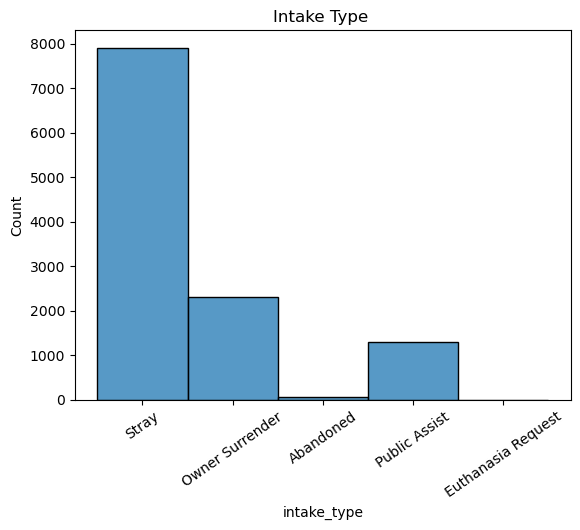

In [57]:
sns.histplot(train.intake_type)
plt.xticks(rotation=35)
plt.title('Intake Type ')
plt.show()

In [58]:
train.outcome_type.value_counts()

Adoption           7808
Return to Owner    3391
Euthanasia          321
Died                 48
Name: outcome_type, dtype: int64

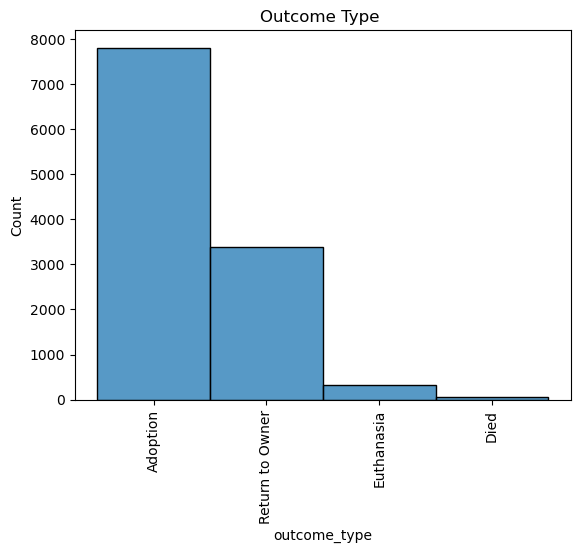

In [59]:
sns.histplot(train.outcome_type)
plt.xticks(rotation='vertical')
plt.title('Outcome Type ')
plt.show()

In [60]:
train.breed.value_counts().sort_values(ascending=False)

Pit Bull                 3739
Labrador Retriever       2900
Chihuahua                1832
German Shepherd          1236
Boxer                     421
Border Collie             400
Staffordshire             320
Australian Cattle Dog     320
Dachshund                 304
Rat Terrier                96
Name: breed, dtype: int64

In [61]:
breeds = pd.DataFrame(train[['breed']].value_counts())
breeds.head(10)

,0
breed,
Pit Bull,3739
Labrador Retriever,2900
Chihuahua,1832
German Shepherd,1236
Boxer,421
Border Collie,400
Australian Cattle Dog,320
Staffordshire,320
Dachshund,304


In [62]:
# Rename column
breeds = breeds.rename(columns={0:'count'})
breeds.head(3)

,count
breed,
Pit Bull,3739
Labrador Retriever,2900
Chihuahua,1832


In [63]:
breeds = breeds.reset_index()

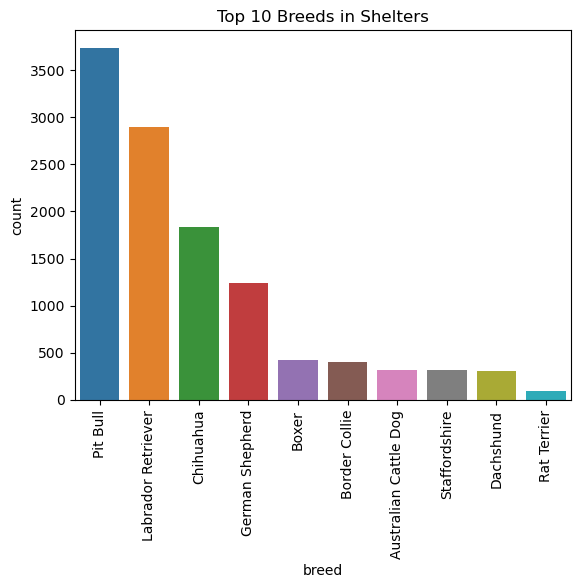

In [64]:
sns.barplot(x='breed', y='count', data=breeds.head(10))
plt.xticks(rotation='vertical')
plt.title('Top 10 Breeds in Shelters')
plt.show()

In [65]:
train.breed.value_counts()

Pit Bull                 3739
Labrador Retriever       2900
Chihuahua                1832
German Shepherd          1236
Boxer                     421
Border Collie             400
Staffordshire             320
Australian Cattle Dog     320
Dachshund                 304
Rat Terrier                96
Name: breed, dtype: int64

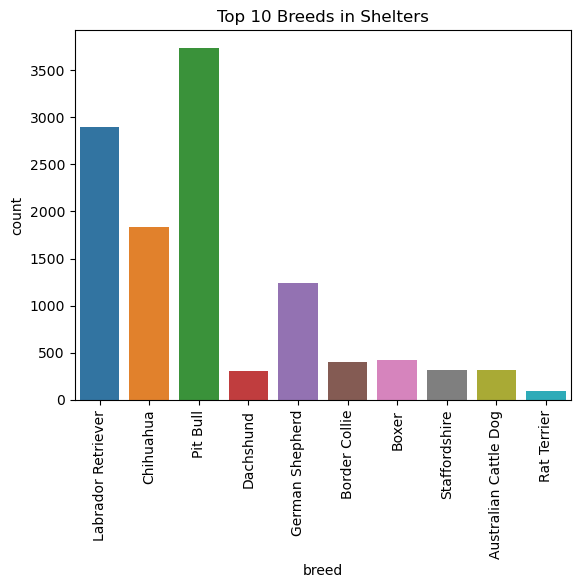

In [66]:
sns.countplot(x='breed', data=train)
plt.xticks(rotation='vertical')
plt.title('Top 10 Breeds in Shelters')
plt.show()

In [67]:
# How to visualize time in shelter


# < 90 days
three_mo = train[train['time_in_shelter'] < 90]
three_mo.head(3)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter,age_months_outcome,age_years_outcome
8931,A750482,2017-11-25 02:16:00,Owner Surrender,Normal,Dog,1 year,2017-11-26 12:19:00,2016-09-28,Adoption,Neutered Male,1 year,Labrador Retriever,Black/White,1,< 30 days,14.0,1 year
18986,A762757,2017-11-26 01:48:00,Owner Surrender,Normal,Dog,9 years,2018-01-19 02:05:00,2008-11-26,Adoption,Neutered Male,9 years,Labrador Retriever,Black/White,54,30+ days,111.0,1+ years
171735,A723566,2016-04-03 12:52:00,Owner Surrender,Normal,Dog,1 year,2016-04-10 05:33:00,2015-01-03,Adoption,Intact Female,1 year,Chihuahua,Black/Brown,6,< 30 days,15.0,1 year


## Does their time in a shelter decrease their desirability to potential adoptive parents?


In [68]:
train.head(3)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter,age_months_outcome,age_years_outcome
148146,A785257,2018-11-29 01:24:00,Stray,Normal,Dog,1 month,2019-12-19 01:31:00,2018-10-05,Adoption,Spayed Female,1 year,Labrador Retriever,Black/White,385,30+ days,15.0,1 year
8931,A750482,2017-11-25 02:16:00,Owner Surrender,Normal,Dog,1 year,2017-11-26 12:19:00,2016-09-28,Adoption,Neutered Male,1 year,Labrador Retriever,Black/White,1,< 30 days,14.0,1 year
18986,A762757,2017-11-26 01:48:00,Owner Surrender,Normal,Dog,9 years,2018-01-19 02:05:00,2008-11-26,Adoption,Neutered Male,9 years,Labrador Retriever,Black/White,54,30+ days,111.0,1+ years


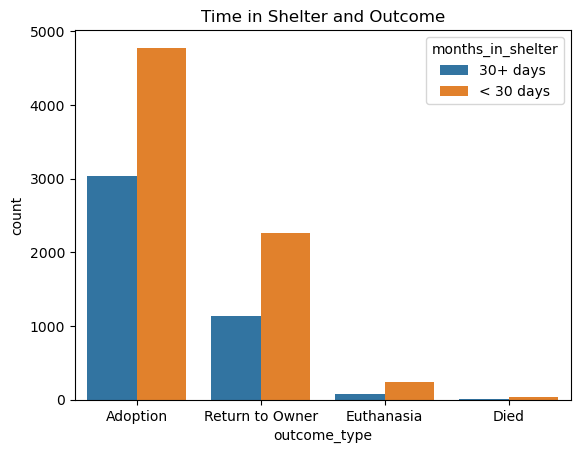

In [69]:
# Countplot for outcome rates depending on time in shelter
sns.countplot(x='outcome_type', data=train, hue='months_in_shelter')
plt.title('Time in Shelter and Outcome')
plt.show()

In [70]:
breeds_df = pd.DataFrame(train.breed.value_counts(normalize=True))
breeds_df.head(20)

,breed
Pit Bull,0.323219
Labrador Retriever,0.250692
Chihuahua,0.158368
German Shepherd,0.106846
Boxer,0.036393
Border Collie,0.034578
Staffordshire,0.027663
Australian Cattle Dog,0.027663
Dachshund,0.026279
Rat Terrier,0.008299


In [71]:
train.breed.unique()

array(['Labrador Retriever', 'Chihuahua', 'Pit Bull', 'Dachshund',
       'German Shepherd', 'Border Collie', 'Boxer', 'Staffordshire',
       'Australian Cattle Dog', 'Rat Terrier'], dtype=object)

In [72]:
breeds_df = pd.DataFrame(train.breed.value_counts(normalize=True))
breeds_df.head(10)

,breed
Pit Bull,0.323219
Labrador Retriever,0.250692
Chihuahua,0.158368
German Shepherd,0.106846
Boxer,0.036393
Border Collie,0.034578
Staffordshire,0.027663
Australian Cattle Dog,0.027663
Dachshund,0.026279
Rat Terrier,0.008299


### Stats Test

In [73]:
x = train[train.outcome_type == 'Adoption']['time_in_shelter']

In [74]:
stats.ttest_1samp(x, train.time_in_shelter.mean())

Ttest_1sampResult(statistic=-8.050719501320778, pvalue=9.44777954906377e-16)

## Does the animal's breed influence their chances of being placed in a home?


In [75]:
train.breed.value_counts().head(10)

Pit Bull                 3739
Labrador Retriever       2900
Chihuahua                1832
German Shepherd          1236
Boxer                     421
Border Collie             400
Staffordshire             320
Australian Cattle Dog     320
Dachshund                 304
Rat Terrier                96
Name: breed, dtype: int64

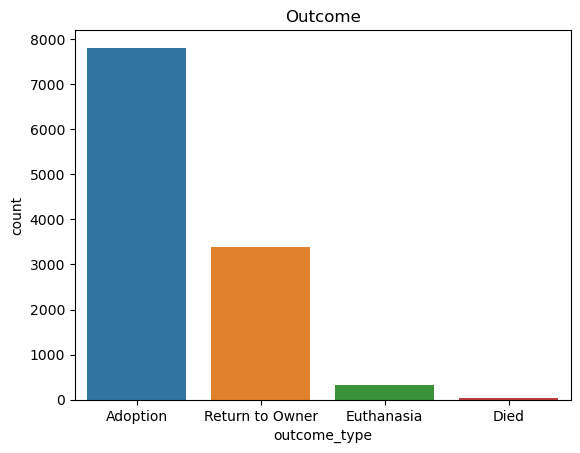

In [76]:
sns.countplot(x= 'outcome_type', data= train)
plt.title('Outcome')
plt.show()

In [77]:

top_five = ['Pit Bull','Labrador Retriever','Chihuahua','German Shepherd','Australian Cattle Dog']

top_four = ['Pit Bull','Labrador Retriever','Chihuahua','German Shepherd']



top_five_train = train[train.breed.isin(top_five)]
top_four_train = train[train.breed.isin(top_four)]

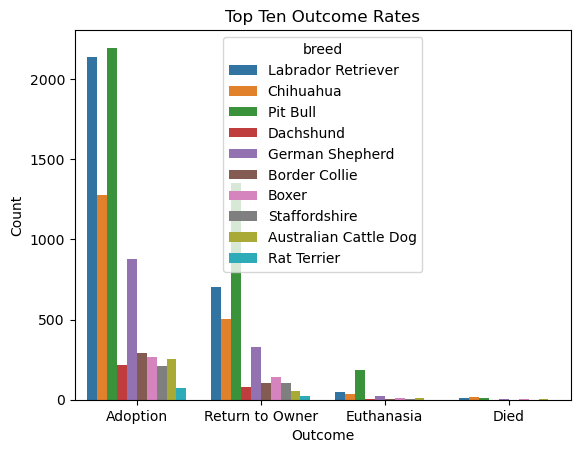

In [78]:
sns.countplot(x='outcome_type', data=train, hue='breed')
plt.title('Top Ten Outcome Rates')
plt.ylabel('Count')
plt.xlabel('Outcome')
plt.show()

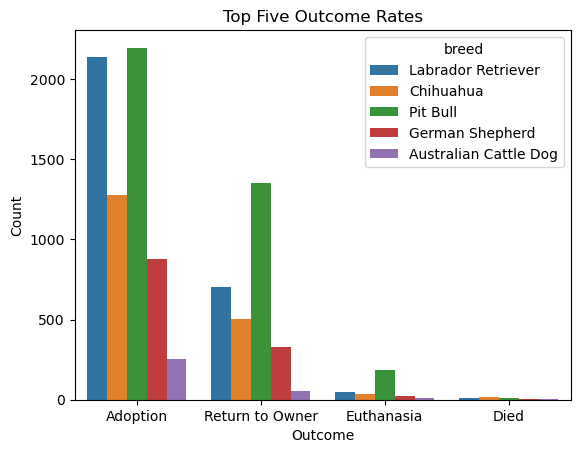

In [79]:
sns.countplot(x='outcome_type', data=top_five_train, hue='breed')
plt.title('Top Five Outcome Rates')
plt.ylabel('Count')
plt.xlabel('Outcome')
plt.show()

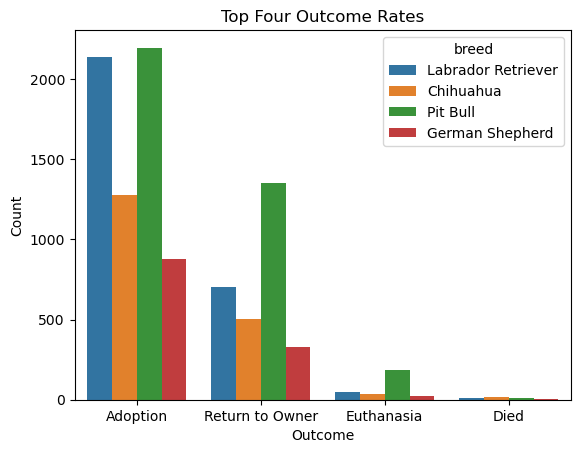

In [80]:
sns.countplot(x='outcome_type', data=top_four_train, hue='breed')
plt.title('Top Four Outcome Rates')
plt.ylabel('Count')
plt.xlabel('Outcome')
plt.show()

In [81]:
train[train['breed'] == 'German Shepherd']

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter,age_months_outcome,age_years_outcome
3785,A837860,2021-08-05 11:51:00,Owner Surrender,Normal,Dog,1 year,2021-10-19 04:17:00,2020-06-29,Adoption,Neutered Male,1 year,German Shepherd,Black/Brown,74,30+ days,16.0,1 year
110354,A779885,2018-09-06 01:11:00,Stray,Normal,Dog,2 years,2018-10-16 06:25:00,2016-09-06,Adoption,Neutered Male,2 years,German Shepherd,Black/White,40,30+ days,26.0,1+ years
64185,A804542,2019-11-05 09:06:00,Stray,Normal,Dog,2 years,2019-11-10 02:51:00,2017-09-15,Adoption,Neutered Male,2 years,German Shepherd,Tan,4,< 30 days,26.0,1+ years
155138,A840793,2021-08-14 12:01:00,Stray,Normal,Dog,4 months,2021-08-20 05:49:00,2021-04-14,Adoption,Neutered Male,4 months,German Shepherd,Black/Tan,5,< 30 days,4.0,1 year
169039,A830091,2021-03-08 12:25:00,Stray,Normal,Dog,2 years,2021-03-13 01:40:00,2019-03-02,Adoption,Spayed Female,2 years,German Shepherd,Black/Brown,4,< 30 days,25.0,1+ years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133463,A785053,2018-11-25 05:14:00,Stray,Normal,Dog,3 months,2019-02-05 07:19:00,2018-08-25,Adoption,Spayed Female,5 months,German Shepherd,Tan/White,72,30+ days,5.0,1 year
20498,A666183,2013-10-28 01:31:00,Stray,Normal,Dog,5 years,2013-11-12 07:07:00,2008-10-28,Adoption,Spayed Female,5 years,German Shepherd,Brown,15,< 30 days,61.0,1+ years
87965,A725130,2016-04-26 12:02:00,Stray,Normal,Dog,11 months,2016-05-02 12:08:00,2015-05-26,Return to Owner,Neutered Male,11 months,German Shepherd,Black,6,< 30 days,11.0,1 year
152673,A769552,2018-04-06 12:18:00,Stray,Normal,Dog,9 months,2018-04-10 06:29:00,2017-06-06,Adoption,Neutered Male,10 months,German Shepherd,Black/Tan,3,< 30 days,10.0,1 year


In [82]:
train.breed.value_counts()

Pit Bull                 3739
Labrador Retriever       2900
Chihuahua                1832
German Shepherd          1236
Boxer                     421
Border Collie             400
Staffordshire             320
Australian Cattle Dog     320
Dachshund                 304
Rat Terrier                96
Name: breed, dtype: int64

### Stats Test

In [83]:
stats.spearmanr(train.breed, train.outcome_type)

SpearmanrResult(correlation=0.0897218997174708, pvalue=4.104787752138676e-22)

## Does their color influence their chances of being placed in a home?


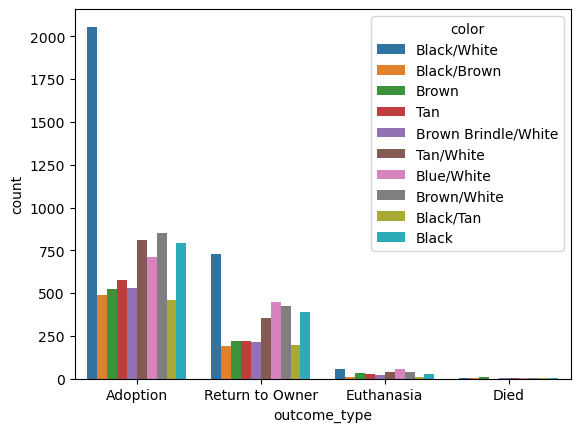

In [84]:
sns.countplot(x='outcome_type', data=train, hue='color')
plt.show()

### Stats Test

In [85]:
train.head()

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter,age_months_outcome,age_years_outcome
148146,A785257,2018-11-29 01:24:00,Stray,Normal,Dog,1 month,2019-12-19 01:31:00,2018-10-05,Adoption,Spayed Female,1 year,Labrador Retriever,Black/White,385,30+ days,15.0,1 year
8931,A750482,2017-11-25 02:16:00,Owner Surrender,Normal,Dog,1 year,2017-11-26 12:19:00,2016-09-28,Adoption,Neutered Male,1 year,Labrador Retriever,Black/White,1,< 30 days,14.0,1 year
18986,A762757,2017-11-26 01:48:00,Owner Surrender,Normal,Dog,9 years,2018-01-19 02:05:00,2008-11-26,Adoption,Neutered Male,9 years,Labrador Retriever,Black/White,54,30+ days,111.0,1+ years
171735,A723566,2016-04-03 12:52:00,Owner Surrender,Normal,Dog,1 year,2016-04-10 05:33:00,2015-01-03,Adoption,Intact Female,1 year,Chihuahua,Black/Brown,6,< 30 days,15.0,1 year
77948,A730755,2016-07-10 09:44:00,Stray,Normal,Dog,1 year,2016-07-31 06:57:00,2015-07-10,Adoption,Neutered Male,1 year,Pit Bull,Brown,20,< 30 days,13.0,1 year


In [86]:
stats.spearmanr(train.color, train.outcome_type)

SpearmanrResult(correlation=0.013043292526972715, pvalue=0.1606840438348742)

## Does their age influence their chances of being adopted?

In [87]:
train.age_upon_outcome.unique()

array(['1 year', '9 years', '10 years', '2 months', '4 weeks', '4 years',
       '2 years', '6 years', '4 months', '9 months', '6 months',
       '3 years', '7 months', '10 months', '3 months', '5 years',
       '11 months', '5 months', '7 years', '1 month', '8 months',
       '8 years', '13 years', '15 years', '16 years', '14 years',
       '11 years', '1 weeks', '12 years', '2 weeks', '3 days', '19 years',
       '17 years', '2 days', '3 weeks', '18 years', '1 week', '5 days',
       '4 days'], dtype=object)

In [88]:
train.age_upon_outcome.value_counts()

1 year       2263
2 years      2241
3 years      1136
2 months      968
4 years       670
5 years       584
6 years       370
7 years       320
8 years       281
3 months      267
4 months      259
6 months      243
5 months      243
8 months      237
10 months     237
1 month       232
10 years      180
7 months      155
9 years       152
9 months      137
11 months     109
12 years       66
11 years       57
13 years       42
14 years       33
15 years       21
1 weeks        18
2 weeks        12
3 weeks        10
16 years        9
17 years        4
5 days          3
19 years        2
18 years        2
4 weeks         1
3 days          1
2 days          1
1 week          1
4 days          1
Name: age_upon_outcome, dtype: int64

In [89]:
train.age_upon_outcome.dtype

dtype('O')

In [90]:
# date of birth into datetime dtype
#train['date_of_birth'] = pd.to_datetime(train.date_of_birth)

In [91]:
#train['age_months_outcome'] = round(((train.date_outcome - train.date_of_birth).dt.days) / 30)

In [92]:
#train['age_years_outcome'] = round((((train.date_outcome - train.date_of_birth).dt.days) / 30) / 12)

In [93]:
# Created bins of 1 year, 1-2 years, and 2+ years
#train['age_outcome'] = np.where(train.age_outcome <= 12, '1 year', train.age_outcome)
#train['age_outcome'] = np.where(((train.age_outcome > '12') & (train.age_outcome <='24')), '2 years', train.age_outcome)
#train['age_outcome'] = np.where(train.age_outcome > '24', '2+ years', train.age_outcome)



In [94]:
#train['age_years_outcome'] = np.where(train.age_years_outcome <= 1, '1 year', '1+ years')
#train.sample(10)

<AxesSubplot:xlabel='outcome_type', ylabel='count'>

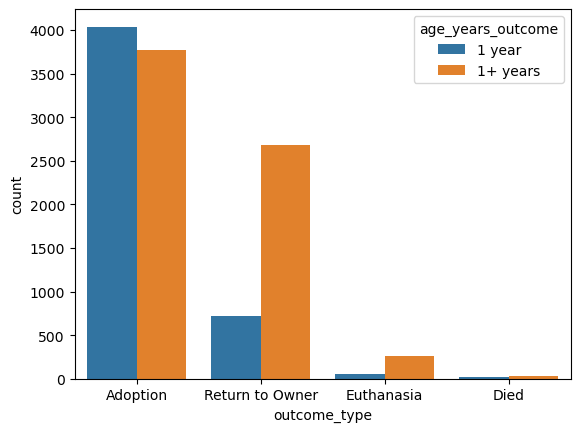

In [95]:
sns.countplot(x='outcome_type', data=train, hue='age_years_outcome')

### Stats Test

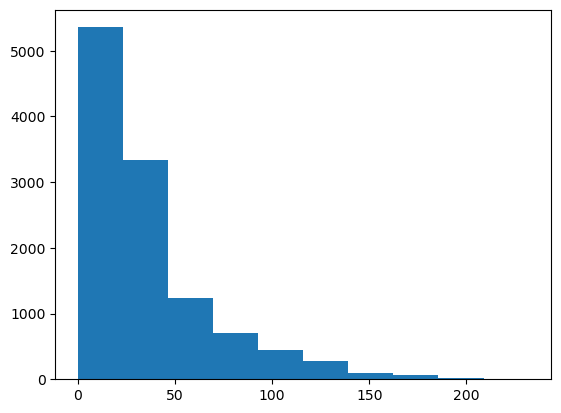

In [96]:
plt.hist(train.age_months_outcome)
plt.show()

In [97]:
stats.spearmanr(train.age_upon_outcome, train.outcome_type)

SpearmanrResult(correlation=0.13204579967746163, pvalue=3.7159513902730876e-46)

### Try to make 1 year, 1-2 year, 2+ year viz after mvp

In [98]:
train.head(3)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter,age_months_outcome,age_years_outcome
148146,A785257,2018-11-29 01:24:00,Stray,Normal,Dog,1 month,2019-12-19 01:31:00,2018-10-05,Adoption,Spayed Female,1 year,Labrador Retriever,Black/White,385,30+ days,15.0,1 year
8931,A750482,2017-11-25 02:16:00,Owner Surrender,Normal,Dog,1 year,2017-11-26 12:19:00,2016-09-28,Adoption,Neutered Male,1 year,Labrador Retriever,Black/White,1,< 30 days,14.0,1 year
18986,A762757,2017-11-26 01:48:00,Owner Surrender,Normal,Dog,9 years,2018-01-19 02:05:00,2008-11-26,Adoption,Neutered Male,9 years,Labrador Retriever,Black/White,54,30+ days,111.0,1+ years


# Modeling

In [99]:
# make baseline

In [100]:
drop_these = ['animal_id', 'date_intake','intake_type', 'intake_condition',
              'animal_type','age_upon_intake','age_upon_outcome','months_in_shelter',
             'age_years_outcome','date_outcome','date_of_birth']



In [101]:
train_modeling = train.copy()
val_modeling = val.copy()
test_modeling = test.copy()

In [102]:
train_modeling = train_modeling.drop(drop_these, axis=1)
val_modeling = val_modeling.drop(drop_these, axis=1)
test_modeling = test_modeling.drop(drop_these, axis=1)

In [103]:
val_modeling.head()

,outcome_type,sex_upon_outcome,breed,color,time_in_shelter,age_months_outcome
18268,Adoption,Neutered Male,Pit Bull,Tan/White,4,3.0
25552,Adoption,Neutered Male,Chihuahua,Brown,52,53.0
2451,Adoption,Neutered Male,German Shepherd,Black/Tan,19,2.0
105505,Adoption,Spayed Female,Pit Bull,Brown,84,64.0
91828,Adoption,Spayed Female,Pit Bull,Tan,25,9.0


In [104]:
train_modeling = pd.get_dummies(train_modeling, columns=['breed','color','sex_upon_outcome'])
val_modeling = pd.get_dummies(val_modeling, columns=['breed','color','sex_upon_outcome'])
test_modeling = pd.get_dummies(test_modeling, columns=['breed','color','sex_upon_outcome'])

In [105]:
train_modeling.head(3)

,outcome_type,time_in_shelter,age_months_outcome,breed_Australian Cattle Dog,breed_Border Collie,breed_Boxer,breed_Chihuahua,breed_Dachshund,breed_German Shepherd,breed_Labrador Retriever,...,color_Brown,color_Brown Brindle/White,color_Brown/White,color_Tan,color_Tan/White,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
148146,Adoption,385,15.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
8931,Adoption,1,14.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
18986,Adoption,54,111.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## The Trains

In [106]:
X_train = train_modeling.drop(['outcome_type'], axis=1)
y_train = train_modeling.outcome_type

X_val = val_modeling.drop(['outcome_type'], axis=1)
y_val = val_modeling.outcome_type

X_test = test_modeling.drop(['outcome_type'], axis=1)
y_test = test_modeling.outcome_type

## Scale Data


In [107]:
# Scaler Object
mm = MinMaxScaler()

# Fit and Transform
X_train[['time_in_shelter','age_months_outcome']] =\
mm.fit_transform(X_train[['time_in_shelter','age_months_outcome']])

X_val[['time_in_shelter','age_months_outcome']] =\
mm.transform(X_val[['time_in_shelter','age_months_outcome']])

X_test[['time_in_shelter','age_months_outcome']] =\
mm.transform(X_test[['time_in_shelter','age_months_outcome']])

In [108]:
X_train.head(10)

,time_in_shelter,age_months_outcome,breed_Australian Cattle Dog,breed_Border Collie,breed_Boxer,breed_Chihuahua,breed_Dachshund,breed_German Shepherd,breed_Labrador Retriever,breed_Pit Bull,...,color_Brown,color_Brown Brindle/White,color_Brown/White,color_Tan,color_Tan/White,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
148146,0.131642,0.064655,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8931,0.000000,0.060345,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
18986,0.018169,0.478448,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
171735,0.001714,0.064655,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
77948,0.006514,0.056034,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
101046,0.008570,0.568966,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
111428,0.000686,0.008621,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
134822,0.001028,0.051724,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
97654,0.006514,0.008621,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
186617,0.004457,0.056034,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


## Baseline

In [109]:
# Mode of target variable
train.outcome_type.mode()

0    Adoption
Name: outcome_type, dtype: object

In [110]:
train.outcome_type == 'Adoption'

148146     True
8931       True
18986      True
171735     True
77948      True
          ...  
100836     True
57274     False
77859      True
100156     True
114977     True
Name: outcome_type, Length: 11568, dtype: bool

In [111]:
train['baseline'] = train.outcome_type == 'Adoption'
train.head(3)

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter,age_months_outcome,age_years_outcome,baseline
148146,A785257,2018-11-29 01:24:00,Stray,Normal,Dog,1 month,2019-12-19 01:31:00,2018-10-05,Adoption,Spayed Female,1 year,Labrador Retriever,Black/White,385,30+ days,15.0,1 year,True
8931,A750482,2017-11-25 02:16:00,Owner Surrender,Normal,Dog,1 year,2017-11-26 12:19:00,2016-09-28,Adoption,Neutered Male,1 year,Labrador Retriever,Black/White,1,< 30 days,14.0,1 year,True
18986,A762757,2017-11-26 01:48:00,Owner Surrender,Normal,Dog,9 years,2018-01-19 02:05:00,2008-11-26,Adoption,Neutered Male,9 years,Labrador Retriever,Black/White,54,30+ days,111.0,1+ years,True


In [112]:
train.baseline.count()

11568

In [113]:
train.outcome_type.value_counts().head(1) / train.baseline.count()

Adoption    0.674965
Name: outcome_type, dtype: float64

**Baseline: 0.67**

## Deciscion Tree

In [114]:
# Model Object
clf = DecisionTreeClassifier()

In [115]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [116]:
# For Loop for Max leaf nodes

metrics = []


for i in range(2,31):
    
    # Model Object
    clf = DecisionTreeClassifier(max_depth= 10, max_leaf_nodes= i, random_state=123)
    
    # Fit Object
    clf.fit(X_train, y_train)
    
    train_clf = clf.score(X_train,y_train)
    val_clf = clf.score(X_val, y_val)
    
    output = {'max_leaf_nodes': i,
            'train_accuracy': train_clf,
            'validate_accuracy': val_clf}
    
    metrics.append(output)

dt_df = pd.DataFrame(metrics)
dt_df['difference'] = dt_df.train_accuracy - dt_df.validate_accuracy
dt_df.sort_values('train_accuracy', ascending=False)

,max_leaf_nodes,train_accuracy,validate_accuracy,difference
28,30,0.791840,0.784187,0.007652
27,29,0.791840,0.784187,0.007652
26,28,0.791840,0.784187,0.007652
25,27,0.790629,0.783582,0.007047
24,26,0.789592,0.782775,0.006817
23,25,0.787258,0.784187,0.003071
22,24,0.787258,0.784187,0.003071
21,23,0.787258,0.784187,0.003071
20,22,0.786221,0.782977,0.003244
19,21,0.785875,0.783179,0.002696


Text(0, 0.5, 'Accuracy')

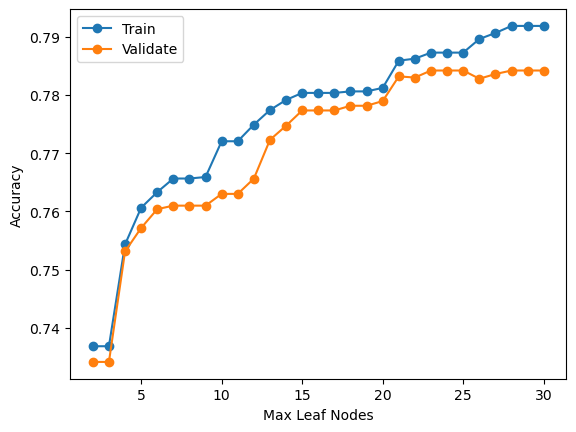

In [117]:
plt.plot(dt_df.max_leaf_nodes, dt_df.train_accuracy, marker='o', label='Train')
plt.plot(dt_df.max_leaf_nodes, dt_df.validate_accuracy, marker='o', label='Validate')
plt.legend()
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')

**Decsion Tree best at Depth of 10 with 16 leaf nodes**

## Random Forest

In [118]:

metrics_rf = []

for i in range(1,11):
    
    # Model Object
    rf = RandomForestClassifier(n_estimators= 200, max_depth= i, random_state=123)
    
    # Fit Object
    rf.fit(X_train, y_train)
    
    # Accuracy Scores
    train_rf = rf.score(X_train,y_train)
    val_rf = rf.score(X_val, y_val)
    
    
    output = {'max_depth': i,
            'train_accuracy': train_rf,
            'validate_accuracy': val_rf}
    
    metrics_rf.append(output)
    

In [119]:
rf_df = pd.DataFrame(metrics_rf)
rf_df['difference'] = rf_df.train_accuracy - rf_df.validate_accuracy
rf_df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.674965,0.675071,-0.000105
1,2,0.706172,0.707140,-0.000968
2,3,0.746024,0.745664,0.000360
3,4,0.774205,0.768858,0.005346
4,5,0.777922,0.771077,0.006845
5,6,0.780947,0.774102,0.006845
6,7,0.783109,0.776119,0.006989
7,8,0.791667,0.781565,0.010102
8,9,0.798237,0.785196,0.013041
9,10,0.809561,0.789835,0.019726


Text(0, 0.5, 'Accuracy')

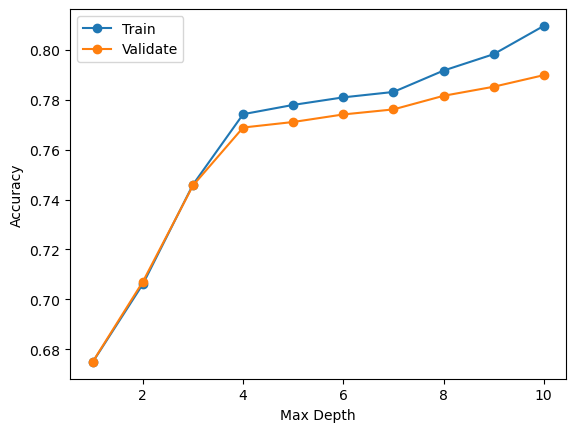

In [120]:
plt.plot(rf_df.max_depth, rf_df.train_accuracy, marker='o', label='Train')
plt.plot(rf_df.max_depth, rf_df.validate_accuracy, marker='o', label='Validate')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')

**RF performs best with n_estimators=200 and max_depth = 6.** 

Train: 0.780064		

Validate: 0.779019

Difference = 0.001045

## KNN 

In [121]:
knn_train = []
knn_val = []

for i in range(2,21):
    
    knn = KNeighborsClassifier(n_neighbors= i)
    knn.fit(X_train, y_train)
    
     # Accuracy Scores
    train_knn = knn.score(X_train,y_train)
    val_knn = knn.score(X_val, y_val)
    
    # Append empty lists
    knn_train.append(train_knn)
    knn_val.append(val_knn)

In [122]:
knn_df = pd.DataFrame({'train': knn_train,'validate': knn_val})
knn_df

,train,validate
0,0.858835,0.733562
1,0.856241,0.744252
2,0.822787,0.751109
3,0.819934,0.748084
4,0.803769,0.754942
5,0.801954,0.748891
6,0.793050,0.750303
7,0.792445,0.747681
8,0.785443,0.749496
9,0.785875,0.745462


In [123]:
knn_df['difference'] = knn_df.train - knn_df.validate
knn_df.sort_values('difference')

,train,validate,difference
16,0.771784,0.746672,0.025112
18,0.769623,0.743445,0.026178
14,0.775588,0.748084,0.027504
13,0.777576,0.749697,0.027879
17,0.774032,0.745260,0.028772
15,0.777057,0.746672,0.030385
12,0.779824,0.748689,0.031135
10,0.781725,0.749496,0.032230
11,0.781466,0.747882,0.033584
8,0.785443,0.749496,0.035947


**KNN does not perform as well as Decision Tree or RF**

## Logistic Regression

In [124]:
lr_train = []
lr_val = []

lr = LogisticRegression(random_state=123)
lr.fit(X_train, y_train)

lr_acc_train = lr.score(X_train, y_train)
lr_acc_val = lr.score(X_val, y_val)

In [125]:
lr_acc_train, lr_acc_val, lr_acc_train - lr_acc_val

(0.7311549100968188, 0.736385639370714, -0.005230729273895229)

## Model Summary

Baseline to Beat: 67%

Decision Tree: Train: 0.7805, Validate: 0.7761, Difference: 0.0044

Random Forest: Train: 0.7801, Validate: 0.7790, Difference: 0.0010

Logistic Reg: Train: 0.7308 , Validate: 0.7306 , Difference: 0.0002

KNN: No good

<div class="alert alert-block alert-success">

**Although Logistic Regression has a lower differnce between train and validate accuracy scores, it's overall accuracy is 5% lower than Random forest. Thus, I will move forward with Random Forest as the final model to use the test data set on**

# Test Model: Random Forest

In [126]:

rf = RandomForestClassifier(n_estimators= 200, max_depth= 6)
    
# Fit Object
rf.fit(X_train, y_train)
    
# Accuracy Scores
train_rf = rf.score(X_train, y_train)
test_rf = rf.score(X_test, y_test)

train_rf, test_rf, train_rf - test_rf

(0.7802558782849239, 0.7679090029041626, 0.01234687538076129)

<div class="alert alert-block alert-success">
Random Forest on Test set: 0.7656
    
Difference: 0.0146

In [127]:
combined_dog.shape

(20658, 17)